# 〖第二次讀書會報告〗
```
  _____||_____     
 ///////////\\\    
///////////  \\\\  
|    _     |  '|   
|[] | | [] | []|   
|   | |   _|   |   
```
* 分類任務建模、探討 Insight
* tfidf、網路圖

# 訓練新聞分類器
目標：使用資料＋trainer訓練出一個可以將新聞大致正確分類的分類器。

### 資料來源

1. 聯合新聞網 (udn)
2. 蘋果新聞 (apple)

包含以下類別的新聞：
* 【體育】
* 【社會】
* 【國際】

### 引入套件

In [1]:
import re
from pprint import pprint
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import math

import networkx as next
from nltk import ngrams, FreqDist

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
# from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm

In [2]:
# Some configs
parent_path = './'
raw_data_path = os.path.join(parent_path, 'raw_data/')
dict_path = os.path.join(parent_path, 'dict/')

In [3]:
import platform
# 設定中文字型
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

def set_font() -> str:
    if platform.system() == 'Darwin':
        plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
        return 'macOS'
    elif platform.system() == 'Windows':
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
        return 'Windows'
    else:
        return 'Unknown'

set_font()

'Windows'

In [4]:
# 讀取資料
df_udn = pd.read_csv(os.path.join(raw_data_path, 'udn.csv'), encoding='utf-8')
df_apple = pd.read_csv(os.path.join(raw_data_path, 'apple.csv'))
df_mobile01 = pd.read_csv(os.path.join(raw_data_path, 'mobile01.csv'))

## 資料前處理

In [5]:
# manipulate data columns
df_udn['artContent'] = df_udn['artUrl']
df_udn = df_udn.drop(columns=['system_id', 'artDate', 'artSecondCatagory', 'artUrl', 'dataSource'])

In [6]:
# 看看有幾篇文章，以及有幾個文章類別
print(f"number of posts: {df_udn.shape[0]}")
# print(f"date range: {(df_udn['artDate'].min(), df_udn['artDate'].max())}")
print(f"category: \n{df_udn['artCatagory'].value_counts()}")

number of posts: 5990
category: 
artCatagory
產經    1308
全球    1218
股市    1095
社會    1048
兩岸     751
運動     567
生活       2
要聞       1
Name: count, dtype: int64


> Note: 資料怪怪的，Tarflow平台爬下來的資料不符合選取的欄位類別。

In [7]:
# 設定統一的類別字典
cat_dict = {
    '全球': '國際',
    '國際': '國際',
    '股市': '股市',
    '運動': '體育',
    '體育': '體育',
    '社會': '社會',
}

In [8]:
list(df_udn)

['artTitle', 'artCatagory', 'artContent']

In [9]:
# define preprocess pipeline
def preprocess(df: pd.DataFrame, cols: list[str] = None) -> pd.DataFrame:
    colNames = list(df)
    df["artContent"] = df.artContent.apply(
        lambda x: re.sub("(http|https)://.*", "", x)
    )
    df["artTitle"] = df["artTitle"].apply(
        lambda x: re.sub("(http|https)://.*", "", x)
    )
    # 只留下中文字
    df["artContent"] = df.artContent.apply(
        lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
    )
    df["artTitle"] = df["artTitle"].apply(
        lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
    )
    df['artCatagory'] = df['artCatagory'].map(cat_dict)
    df['content'] = df['artTitle'] + df['artContent']
    if 'artComment' in colNames:
        df["artComment"] = df["artComment"].apply(
            lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
        )
        df['content'] += df['artComment']
        df = df.drop(columns=['artComment'])
        
    df = df.drop(columns=['artTitle', 'artContent'])
    df = df.dropna()
    return df

In [10]:
df_udn = preprocess(df_udn)

In [11]:
# 確認目前的所有類別
df_udn['artCatagory'].unique()

array(['體育', '國際', '社會', '股市'], dtype=object)

### 斷詞
對`content`欄位進行斷詞

In [16]:
jieba.set_dictionary(os.path.join(dict_path, 'dict.txt'))
with open(os.path.join(dict_path, 'stop_words.txt'), encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [17]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [18]:
df_udn.head()

,artCatagory,content
0,體育,湯普森樂於接受替補地位或許是長留勇士的生存之道湯普森近期連續五場球被勇士教練團降為替補這也是...
1,體育,日職大聯盟之夢想圓滿村上宗隆近兩季須達成業績剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接...
2,體育,洋基第一棒該派誰打索托或許才是最佳人選誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長...
3,體育,中職陳冠宇曾仁和角色互換讓人看不懂的珍瓏棋局近期媒體報導樂天桃猿教練團計畫將先發投手曾仁和轉...
4,體育,中職年新球季六軍未打先轟動總教頭風雲看誰能勝出撰文石毓琪四年前職業棒球雜誌於球春到來開季春訓...


In [19]:
df_udn["words"] = df_udn["content"].apply(getToken).map(" ".join)
df_udn.head()

Building prefix dict from c:\Users\Chi\OneDrive - 國立中山大學\桌面\SA\第三組_HW2\dict\dict.txt ...
Loading model from cache C:\Users\Chi\AppData\Local\Temp\jieba.u2fb26ca1e6bbf8b3aa655fe3b3c85dd5.cache
Loading model cost 0.450 seconds.
Prefix dict has been built successfully.


,artCatagory,content,words
0,體育,湯普森樂於接受替補地位或許是長留勇士的生存之道湯普森近期連續五場球被勇士教練團降為替補這也是...,湯普森 樂於 接受 替補 地位 長留 勇士 生存 之道 湯普森 近期 連續 五場 勇士 教練...
1,體育,日職大聯盟之夢想圓滿村上宗隆近兩季須達成業績剛打完台灣遠征比賽的讀賣巨人返回日本之後準備迎接...,日職 大聯盟 夢想 圓滿 村上 宗隆近 兩季須 達成 業績 打完 台灣 遠征 比賽 讀賣 巨...
2,體育,洋基第一棒該派誰打索托或許才是最佳人選誰是洋基隊史上最偉大的開路先鋒頭一個會想到的八成是隊長...,洋基 第一 索托 最佳 人選 洋基隊 史上 偉大 開路 先鋒 頭一個 想到 隊長 基特 基特...
3,體育,中職陳冠宇曾仁和角色互換讓人看不懂的珍瓏棋局近期媒體報導樂天桃猿教練團計畫將先發投手曾仁和轉...,中職 陳冠宇 曾仁和 角色 互換 珍瓏 棋局 近期 媒體 報導 樂天 桃猿 教練團 計畫 先...
4,體育,中職年新球季六軍未打先轟動總教頭風雲看誰能勝出撰文石毓琪四年前職業棒球雜誌於球春到來開季春訓...,中職 新球季 六軍未 打先 轟動 教頭 風雲 勝出 撰文 石毓琪 四年 職業 棒球 雜誌 球...


In [20]:
df_udn.value_counts("artCatagory", normalize=True)*100

artCatagory
國際    31.008147
股市    27.876782
社會    26.680244
體育    14.434827
Name: proportion, dtype: float64

### 訓練分類模型


In [21]:
data = df_udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集切為70%訓練集，30%測試
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

4700    生成 發展 化工 需求 好轉 南亞 第季 營收 明顯 成長 未來 營收 展望 南亞 預估 營...
4900    佳世達 今年 獲利 唱旺 佳世達 昨日 舉行法 說會 展望 後市 董事長 陳其宏 指出 預期...
1048    美股 連四個 收漲 標普 那指 創新高 費半 勁揚 美股 四大 指數 四日 收漲 標普 指數...
4854    亞光 去年 每股 純益 配息 光學 鏡頭廠 亞光 昨日 公布 去年 純益 億元 年減 每股 ...
212     棒球 姜建銘 球員 退役 不談 遺憾 林智勝 一席 影響 深具 台日 職棒 資歷 退役 好手...
Name: words, dtype: object
4700    股市
4900    股市
1048    國際
4854    股市
212     體育
Name: artCatagory, dtype: object


### 資料轉為DTM格式

In [22]:
# 取 tfidf 前 2000 大的詞
vectorizer = TfidfVectorizer(max_features=1000)
print(vectorizer)

TfidfVectorizer(max_features=1000)


In [23]:
X_train.head()

4700    生成 發展 化工 需求 好轉 南亞 第季 營收 明顯 成長 未來 營收 展望 南亞 預估 營...
4900    佳世達 今年 獲利 唱旺 佳世達 昨日 舉行法 說會 展望 後市 董事長 陳其宏 指出 預期...
1048    美股 連四個 收漲 標普 那指 創新高 費半 勁揚 美股 四大 指數 四日 收漲 標普 指數...
4854    亞光 去年 每股 純益 配息 光學 鏡頭廠 亞光 昨日 公布 去年 純益 億元 年減 每股 ...
212     棒球 姜建銘 球員 退役 不談 遺憾 林智勝 一席 影響 深具 台日 職棒 資歷 退役 好手...
Name: words, dtype: object

In [24]:
# 使用 fit() 建立字典(訓練資料集)
vectorizer.fit(X_train)

# 使用 transform() 轉換資料為向量
vec_train = vectorizer.transform(X_train)
vec_train.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05322209,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.49521371, 0.        ,
        0.        ]])

In [25]:
# 查看目前字典的詞彙
vectorizer.get_feature_names_out()[:10]

array(['一些', '一名', '一場', '一定', '一年', '一度', '一次', '一直', '一起', '一路'],
      dtype=object)

In [26]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

> Note: 拉高 max_features 有機會提高準確率，但是會增加訓練時間
```

now training: clf_logistic
              precision    recall  f1-score   support

          國際       0.96      0.97      0.96       833
          社會       0.97      0.98      0.97       751
          股市       0.98      0.97      0.98       784
          體育       1.00      0.97      0.99       381

    accuracy                           0.97      2749
   macro avg       0.98      0.97      0.97      2749
weighted avg       0.97      0.97      0.97      2749

now training: clf_dtree


              precision    recall  f1-score   support

          國際       0.87      0.86      0.86       833
          社會       0.89      0.92      0.91       751
          股市       0.89      0.90      0.90       784
          體育       0.91      0.87      0.89       381

    accuracy                           0.89      2749
   macro avg       0.89      0.89      0.89      2749
weighted avg       0.89      0.89      0.89      2749

now training: clf_svm
              precision    recall  f1-score   support

          國際       0.96      0.97      0.97       833
          社會       0.97      0.98      0.98       751
          股市       0.99      0.97      0.98       784
          體育       1.00      0.98      0.99       381

    accuracy                           0.98      2749
   macro avg       0.98      0.98      0.98      2749
weighted avg       0.98      0.98      0.98      2749

now training: clf_rf
              precision    recall  f1-score   support

          國際       0.94      0.9

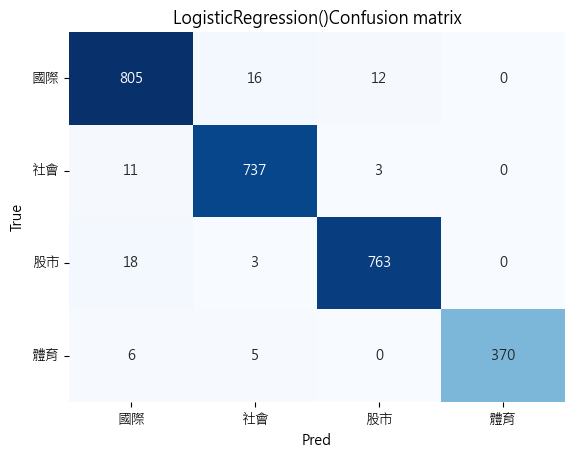

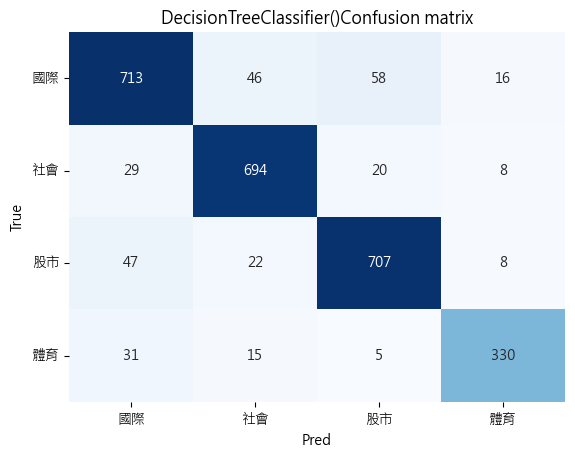

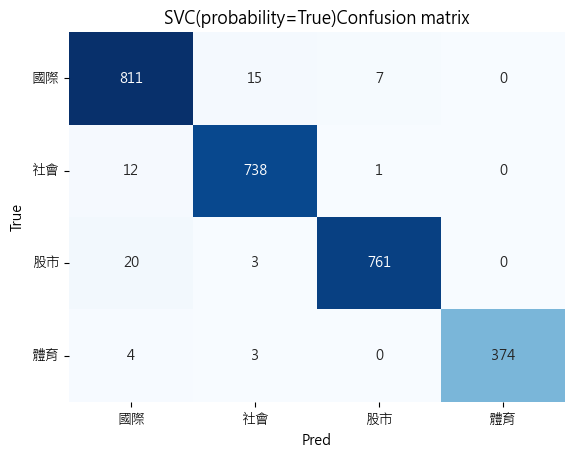

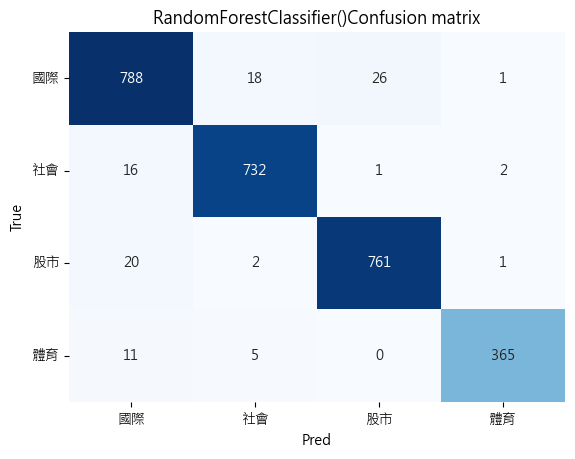

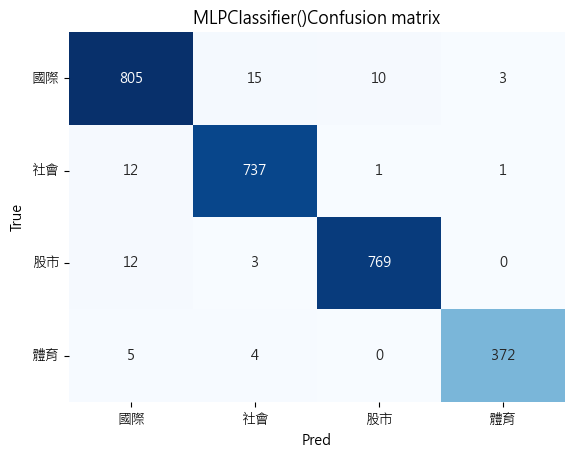

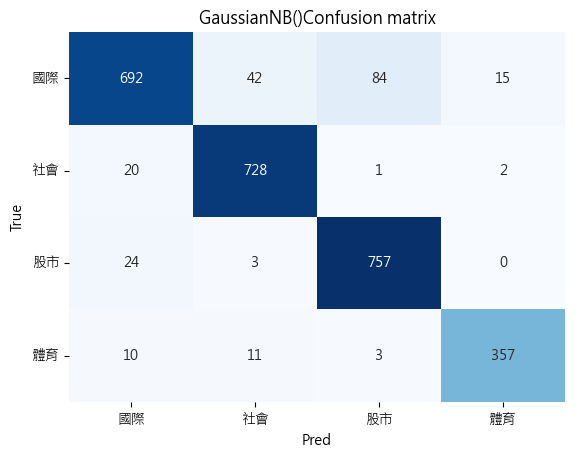

In [27]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
model_set['clf_mlp'] = MLPClassifier()
model_set['clf_gn'] = GaussianNB()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [28]:
# 找出最佳模型存入變數
max = 0
best_model_name = ""
best_model_metric = "f1-score"
best_model = ''

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
        best_model = model_set[k]
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.9763550381957076,
 'macro avg': {'f1-score': 0.9784316864765463,
               'precision': 0.9798564858200338,
               'recall': 0.9771424361680883,
               'support': 2749.0},
 'weighted avg': {'f1-score': 0.9764094479164999,
                  'precision': 0.9765952485928657,
                  'recall': 0.9763550381957076,
                  'support': 2749.0},
 '國際': {'f1-score': 0.9654761904761905,
        'precision': 0.9574970484061394,
        'recall': 0.9735894357743097,
        'support': 833.0},
 '社會': {'f1-score': 0.9774834437086093,
        'precision': 0.9723320158102767,
        'recall': 0.9826897470039947,
        'support': 751.0},
 '股市': {'f1-score': 0.9800386349001932,
        'precision': 0.9895968790637191,
        'recall': 0.9706632653061225,
        'support': 784.0},
 '體育': {'f1-score': 0.990728476821192,
        'precision': 1.0,
        'recall': 0.9816272965879265,
        'support': 381.0}}


> Best Model: SVM 支持向量機
> 相較於其他訓練方法有最高的 f1 value\
> **f1 = 0.978**

In [29]:
print(best_model)
# best_model = model_set['clf_mlp']

SVC(probability=True)


In [30]:
y_pred = best_model.predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          國際       0.97      0.96      0.96       385
          社會       0.96      1.00      0.98       297
          股市       0.99      0.97      0.98       311
          體育       0.99      0.97      0.98       186

    accuracy                           0.98      1179
   macro avg       0.98      0.98      0.98      1179
weighted avg       0.98      0.98      0.98      1179



### logistic regression各個類別影響力最大最小的詞
odds rate: 勝算比

In [31]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

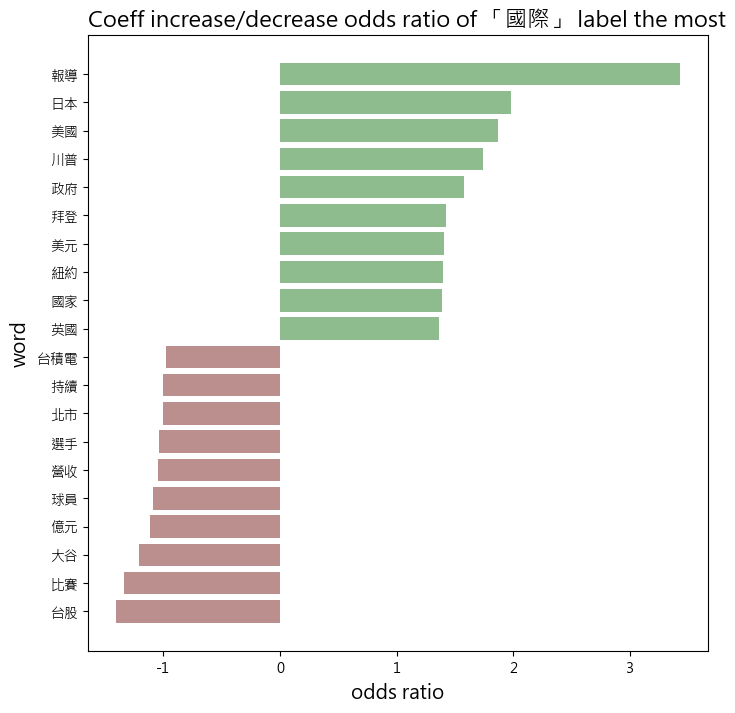

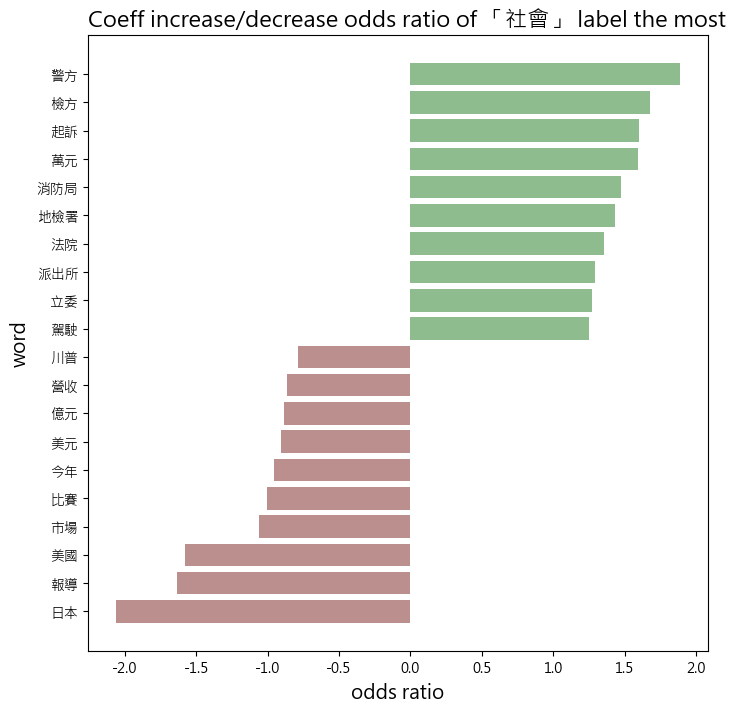

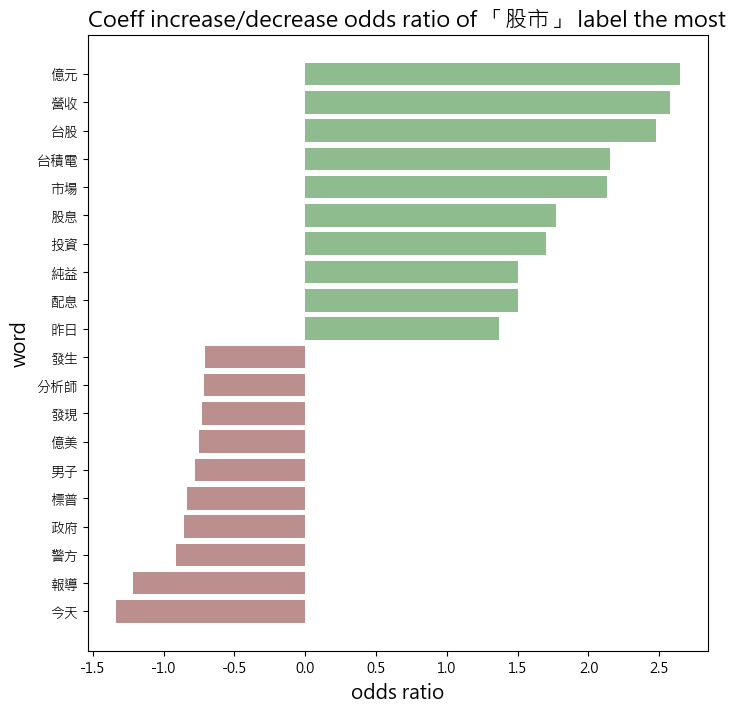

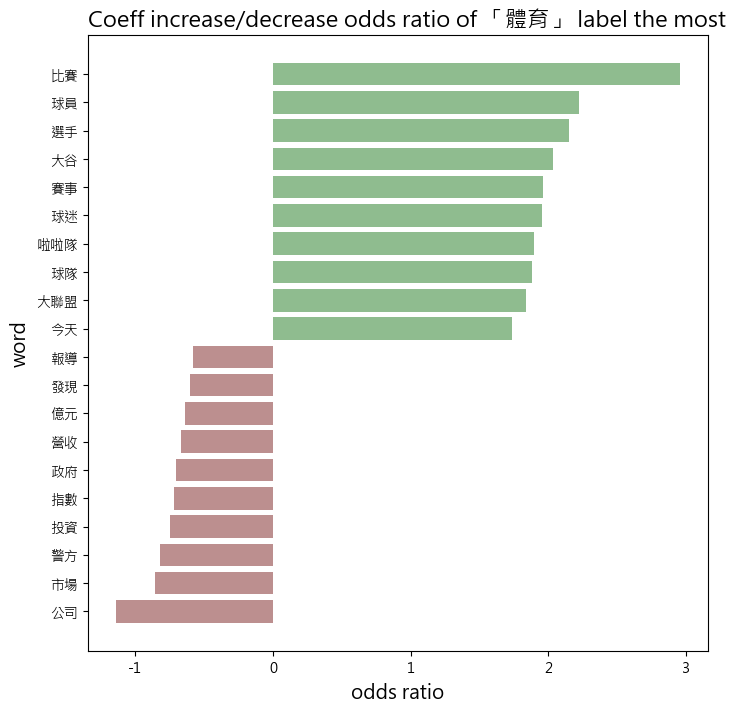

In [32]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

### 觀察
* 「國際」
  * 正面：日本、美國（與其他國家相關詞彙）
  * 負面：台股、比賽（與台灣有關，或是無關領域的詞彙）
* 「社會」
  * 正面：警方、檢方、起訴（與社會新聞相關詞彙）
  * 負面：日本、美國、比賽（其他國家非台灣、或是與社會新聞無關詞彙）
* 「股市」
  * 正面：營收、億元、台股（金融相關詞彙）
  * 負面：報導、警方、男子（非金融相關詞彙）
* 「體育」
  * 正面：比賽、聯盟、球員（體育領域詞彙）
  * 負面：公司、警方、市場（非體育領域詞彙）

## 使用蘋果新聞的資料驗證前面訓練的分類器
**類別**
* 國際
* 社會
* 體育
* 股市 (這個類別會另外驗證)

### 前處理

In [33]:
df_apple = pd.read_csv(os.path.join(raw_data_path, 'apple.csv'))
df_apple = df_apple.drop(columns=['system_id' ,'artDate','artUrl', 'dataSource'])

In [34]:
df_apple.head()

,artTitle,artCatagory,artContent
0,老闆過世「業績暴漲500％」 顧客鈔票送別！業者疾呼理性消費,國際,【劉育良／綜合報導】中國娃哈哈集團創始人、董事長宗慶后，2月25日因病去世，享年79歲，2月...
1,美參議員致函瓜地馬拉總統 肯定台瓜邦誼重要,國際,包括美國聯邦參議員盧比歐在內共7位參議員周四（2/29）聯合致函瓜地馬拉總統阿雷巴洛，肯定台...
2,俄國異議人士納瓦尼下葬莫斯科 上萬追悼民眾怒吼：普丁是殺人兇手,國際,【陳怡妏／綜合外電】上月16日在北極圈監獄過世的俄羅斯反對派領袖納瓦尼，1日在莫斯科舉行葬禮...
3,路透：德意志銀行擬向中國世茂集團提清算訴訟,國際,再有中國房地產商面臨被清算危機。路透社今天報導，德意志銀行正準備在香港向中國世茂集團提出清算...
4,戰亂悲歌！加薩饑民搶糧112人死 以軍遭控「大屠殺」開槍爆頭,國際,【張翠蘭／綜合外電】遭到以色列報復性攻擊的加薩走廊，周四（2/29）傳出逾100等待援助物資...


In [35]:
# 移除網址格式
df_apple["artContent"].str.replace("(http|https)://.*", "", regex=True)
df_apple["artTitle"].str.replace("(http|https)://.*", "", regex=True)
df_apple["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
df_apple["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
df_apple["content"] = df_apple["artTitle"] + df_apple["artContent"]
df_apple = df_apple.drop(columns=['artTitle', 'artContent'])

df_apple["words"] = df_apple["content"].apply(getToken).map(" ".join)
df_apple.head()

,artCatagory,content,words
0,國際,老闆過世「業績暴漲500％」 顧客鈔票送別！業者疾呼理性消費【劉育良／綜合報導】中國娃哈哈集...,老闆 過世 業績 暴漲 500 顧客 鈔票 送別 業者 疾呼 理性 消費 劉育良 綜合 報導...
1,國際,美參議員致函瓜地馬拉總統 肯定台瓜邦誼重要包括美國聯邦參議員盧比歐在內共7位參議員周四（2/...,參議員 致函 瓜地馬拉 總統 肯定 台瓜 邦誼 重要 包括 美國 聯邦 參議員 盧比歐 在內...
2,國際,俄國異議人士納瓦尼下葬莫斯科 上萬追悼民眾怒吼：普丁是殺人兇手【陳怡妏／綜合外電】上月16日...,俄國 異議 人士 納瓦尼 下葬 莫斯科 追悼 民眾 怒吼 普丁 兇手 陳怡 綜合 外電 上月...
3,國際,路透：德意志銀行擬向中國世茂集團提清算訴訟再有中國房地產商面臨被清算危機。路透社今天報導，德...,路透 德意志 銀行 擬向 中國 世茂 集團 清算 訴訟 中國 房地產商 面臨 清算 危機 路...
4,國際,戰亂悲歌！加薩饑民搶糧112人死 以軍遭控「大屠殺」開槍爆頭【張翠蘭／綜合外電】遭到以色列報...,戰亂 悲歌 加薩 饑民 搶糧 112 人死 遭控 大屠殺 開槍 爆頭 張翠蘭 綜合 外電 遭...


In [36]:
# 查看標籤類別
df_apple['artCatagory'].value_counts()

artCatagory
國際    336
社會    334
政治    277
體育    112
Name: count, dtype: int64

In [37]:
# 更改標籤名稱+去除不需要的值
df_apple['artCatagory'] = df_apple['artCatagory'].map(cat_dict)
df_apple = df_apple.dropna()
df_apple['artCatagory'].value_counts()

artCatagory
國際    336
社會    334
體育    112
Name: count, dtype: int64

In [38]:
# feature 與 label 分開
X = df_apple['words']
y = df_apple['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          國際       0.89      0.94      0.92       336
          社會       0.95      0.93      0.94       334
          體育       0.98      0.86      0.91       112

    accuracy                           0.92       782
   macro avg       0.94      0.91      0.92       782
weighted avg       0.93      0.92      0.92       782



In [39]:
# 查看結果
df_apple['pred'] = y_pred

將分類錯誤的文本列出來，觀察有何貓膩。

In [40]:
df_diff = df_apple[df_apple['artCatagory']!=df_apple['pred']][['words', 'artCatagory', 'pred']]
df_diff.head(10)

,words,artCatagory,pred
6,驚悚片 拉手 撲救 失敗 司機 慘嚎 陀螺 遭兩車 夾擊 劉育良 綜合 報導 土耳其 伊斯坦...,國際,社會
14,提供 人頭戶 月領 青年 坐牢 15 李艾倫 綜合 外電 詐騙案 層出不窮 新加坡 21 青...,國際,社會
32,狗狗 神射 橡皮筋 全部 命中 驚呆 上學 劉育良 綜合 報導 國外 社群 平台 瘋傳 一段...,國際,體育
34,曼谷 杜絕 計程車 喊價 擬發 優良 計程車 認證 標章 遊客 曼谷 遊玩 遭到 計程車 司...,國際,社會
49,19 歌手 學校 車震 性侵 女童 投案 嘿咻 不知 12 劉育良 綜合 報導 巴西 瑪瑙 ...,國際,社會
51,跑錯 房送 小命 女子 慘死 屋主 誤殺 判關 25 李艾倫 綜合 外電 誤闖 民宅 喪命 ...,國際,社會
66,21 騎士 撞開 警察 攔檢 脖子 正中 步槍 斃命 劉育良 綜合 報導 巴西 聖保羅 一名...,國際,社會
86,奇葩 軸承 GG 慘了 天脹 紫色 求救 牙籤 解套 知齊 綜合 報導 中國 溫州 一名 男...,國際,社會
113,人倫 慘案 日本 長野 陳屍 未滿 10 李艾倫 綜合 外電 日本 警方 周一 表示 周日 ...,國際,社會
136,病患 死前 還沒 上映 沙丘 同鄉 導演 善舉 曝光 急送 筆電 李艾倫 綜合 外電 科幻 ...,國際,社會


觀察這些分類錯誤的文本，不難發現其中出現非常多類似於台灣社會新聞常出現的詞彙，\
例如: 警察、慘死、小命等等。\
要將這些推斷為社會新聞也不是不行，但是就要歸類在國外的社會新聞版。

## 套用 ptt 股票版資料集做測試
* 資料來源：ptt stock  版
* 資料描述：從一月初到三月底有關00940話題的文章


In [41]:
df_940 = pd.read_csv(os.path.join(raw_data_path, 'han_00940.csv'), encoding='utf-8')
df_940.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1706270018.A.53...,[新聞]元大臺灣價值高息ETF准募3／11展開募集,2024-01-26 19:53:36,MikeShiver,Stock,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922001"",...",180.217.136.24,2024-01-27 02:04:03,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,kiversonx17,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC...",118.165.210.174,2024-01-28 02:04:10,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1708249155.A.1C...,[請益]00940的選股邏輯,2024-02-18 17:39:12,humbler,Stock,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""apeople"", ""c...",111.251.198.167,2024-02-19 02:05:29,ptt


In [42]:
df_940 = df_940.drop(['system_id', 'artUrl', 'artDate', 'artPoster', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
df_940.head()

,artTitle,artCatagory,artContent,artComment
0,[新聞]元大臺灣價值高息ETF准募3／11展開募集,Stock,原文標題：元大\n臺灣價值\n高息ETF准募 3／11展開募集\n\n原文連結：\nhttp...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922001"",..."
1,[新聞]元大加入月配息ETF戰場！00940發行價10,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC..."
2,[請益]00940的選股邏輯,Stock,元大新募集的高股息ETF 00940，\n除了發行價10元驚人低之外，\n選股邏輯納入本益比...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""apeople"", ""c..."
3,[標的]2603長榮高股息送錢多多多,Stock,1. 標的：2603長榮\n\n2. 分類：多\n\n3. 分析/正文：紅海至少再亂個幾個月...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""vvnews"", ""cm..."
4,Re:[標的]2603長榮高股息送錢多多多,Stock,https://i.imgur.com/O71Mm0G.jpg\n本來打算$147買長榮 結...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""Cheng0810"", ..."


In [43]:
cat_dict.update({
    'Stock': '股市'
})

In [44]:
df_940 = preprocess(df_940)
df_940.head(3)

,artCatagory,content
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...


In [45]:
# 統一標籤
df_940['artCatagory'] = df_940['artCatagory'].map(cat_dict)
df_940.head()

,artCatagory,content
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...
3,股市,標的長榮高股息送錢多多多標的長榮分類多分析正文紅海至少再亂個幾個月沒問題這也就代表長榮高獲利...
4,股市,標的長榮高股息送錢多多多本來打算買長榮結果發文完隔天不回頭開始起漲只買到的長榮真的哭暈在船上...


In [46]:
jieba.set_dictionary(os.path.join(dict_path, 'dict.txt'))
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    
# 加入自訂的停用字
other_stopwords = ['ETF', '00940', '940', '心得', '新聞', '情報', '標的', '原文標題', '原文連結', '發布時間', '記者署名', '原文內容', '心得/評論', '現在', '目前', '今年', '今天', 
                   '知道', '台灣', '分析/正文', '分類', '內文', '標題', '網址', '今天', '直接', '指出', '表示', '評論', '臺灣', '原文', '超過', '億元', '正文', '至本期止', '記者', '報導', '內容',
                   '應該', '真的', '覺得', '一下', '已經', '也是', '都是', '是否', '今日', '公告', '連結', '股市', '產品', '民眾', '去年', '預期', '預期成長']
stopWords += other_stopwords
df_940['words'] = df_940['content'].apply(getToken).map(' '.join)
df_940.head(3)

Building prefix dict from c:\Users\Chi\OneDrive - 國立中山大學\桌面\SA\第三組_HW2\dict\dict.txt ...
Loading model from cache C:\Users\Chi\AppData\Local\Temp\jieba.u2fb26ca1e6bbf8b3aa655fe3b3c85dd5.cache
Loading model cost 0.415 seconds.
Prefix dict has been built successfully.


,artCatagory,content,words
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...,元大 價值 高息 准募 展開 募集 元大 價值 高息 准募 展開 募集 發布 時間 署名 工...
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...,元大 加入 配息 戰場 發行價 元大 加入 配息 戰場 發行價 元有 收益 平準 金月號 募...
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...,請益 選股 邏輯 元大 募集 股息 發行價 驚人 之外 選股 邏輯 納入 本益比 自由 現金...


In [47]:
# 驗證模型
X = df_940['words']
y = df_940['artCatagory']

y_pred = model_set['clf_mlp'].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred, zero_division=1))

              precision    recall  f1-score   support

          國際       0.00      1.00      0.00         0
          社會       0.00      1.00      0.00         0
          股市       1.00      0.94      0.97       195
          體育       0.00      1.00      0.00         0

    accuracy                           0.94       195
   macro avg       0.25      0.99      0.24       195
weighted avg       1.00      0.94      0.97       195



### 分析分類錯誤原因

In [48]:
# 把預測結果併入 dataframe
df_940['pred'] = y_pred
df_940.head()

,artCatagory,content,words,pred
0,股市,新聞元大臺灣價值高息准募展開募集原文標題元大臺灣價值高息准募展開募集原文連結發布時間記者署名...,元大 價值 高息 准募 展開 募集 元大 價值 高息 准募 展開 募集 發布 時間 署名 工...,股市
1,股市,新聞元大加入月配息戰場發行價原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發...,元大 加入 配息 戰場 發行價 元大 加入 配息 戰場 發行價 元有 收益 平準 金月號 募...,股市
2,股市,請益的選股邏輯元大新募集的高股息除了發行價元驚人低之外選股邏輯納入本益比自由現金流股東權益報...,請益 選股 邏輯 元大 募集 股息 發行價 驚人 之外 選股 邏輯 納入 本益比 自由 現金...,股市
3,股市,標的長榮高股息送錢多多多標的長榮分類多分析正文紅海至少再亂個幾個月沒問題這也就代表長榮高獲利...,長榮 股息 送錢 長榮 分析 紅海 至少 再亂個 幾個 問題 這也 代表 長榮 獲利 繼續 ...,股市
4,股市,標的長榮高股息送錢多多多本來打算買長榮結果發文完隔天不回頭開始起漲只買到的長榮真的哭暈在船上...,長榮 股息 送錢 打算 長榮 發文 完隔天 回頭 起漲 買到 長榮 哭暈 以下 長榮 操作 ...,股市


In [49]:
# 查看預測錯誤的文章
df_940[df_940['artCatagory'] != df_940['pred']][['words', 'artCatagory', 'pred']]

,words,artCatagory,pred
9,長榮 所屬 全球 海洋 聯盟 延長 合作 五年 長榮 所屬 全球 海洋 聯盟 延長 合作 五...,股市,體育
67,快訊 關門 第一槍 玉山 宣布 停路 限通 筆前 這波 資金 潮買 股息 無法 想像 可怕 ...,股市,國際
71,快訊 關門 第一槍 玉山 宣布 政府 反向 思考 推行 股息 有助於 降低 金融 詐騙 年紀...,股市,社會
85,快訊 募集 倒數 富邦 證突 資料 金融業 拆款 利率 除夕 天天 過年 推錢 大量 流出 ...,股市,國際
104,超夯 楊金龍 一窩蜂 效應 超夯 楊金龍 一窩蜂 效應 跳下去 作者 徐筱嵐 央行 總裁 楊...,股市,國際
105,席捲 市場 央行 總裁 示警 小心 席捲 市場 央行 總裁 示警 小心 羊群 效應 發布 時...,股市,國際
106,電價 喊漲 拉高 通膨 央行 總裁 上半年 電價 喊漲 拉高 通膨 央行 總裁 上半年 降息...,股市,國際
122,恐慌 急下 元大 一直 有個 疑惑 大部份 老一輩 以上 台灣人 有錢 一檔 湧入 上千億 ...,股市,國際
127,新北 股票 投資 遭詐警 新北 股票 投資 遭詐警 埋伏 車手 發布 時間 署名 孟謙 新北...,股市,社會
147,謝金河 看之亂 政府 引導 龐大 謝金河 看之亂 政府 引導 龐大 游資 核心 問題 發布 ...,股市,國際


我們挑出 i=9 的文件，這份文件包含的字詞如下:

In [50]:
pd.DataFrame(df_940['words'][9].split(' ')).value_counts().reset_index().rename({0: 'word'}, axis=1)

,word,count
0,聯盟,30
1,長榮,19
2,咕嚕,14
3,海運,12
4,海洋,8
...,...,...
277,打造,1
278,拆夥,1
279,拉根,1
280,持續,1


由上面的詞彙出現頻率我們可以看到，「聯盟」出現 32 次頻率非常高，\
而「聯盟」這個詞彙在【體育】這個類別的 regression model 中的 odd ratio 相對較高，\
這可能導致此文章被歸類在【體育】類別。

# Tfidf、網路圖

```
 /\_/\   
( o.o )  
 > ^ <   
```

## TF-IDF

In [51]:
#匯入資料
df = pd.read_csv(os.path.join(raw_data_path,'00940.csv'), encoding = 'UTF-8')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,kiversonx17,Stock,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SuGK"", ""cmtC...",118.165.210.174,2024-01-28 02:04:10,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,steveisaman,Stock,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""pc007ya"", ""c...",36.234.78.172,2024-02-02 02:07:58,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,smarthome,Stock,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""abc0922002"",...",42.76.248.131,2024-02-03 02:13:51,ptt


In [52]:
df_metadata = df.copy()

### 去除不必要的欄位
經過處理的資料剩下五個columns，分別是：
* `system_id`
* `artUrl`
* `artTitle`
* `artDate`
* `artContent`

In [53]:
df_sentenced = df_metadata.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis = 1)
df_sentenced['sentence'] = df_sentenced['artContent'].apply(lambda cont: re.sub(pattern=r'[^\u4e00-\u9fff]+', repl='', string=cont))
df_sentenced.head(3)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...


### Tokenize
使用原先提供的斷詞字典進行斷字，並額外加入自定義字典。\
接著進行停用詞過濾，根據圖表結果增加額外的自定義停用詞。

In [54]:
jieba.set_dictionary(os.path.join(dict_path, 'dict.txt'))
jieba.load_userdict(os.path.join(dict_path, 'user_dict.txt'))
jieba.load_userdict(os.path.join(dict_path, 'user_dictionary.txt'))

with open(os.path.join(dict_path, 'stop_words.txt'), 'r', encoding='utf-8') as file:
    stopwords = file.read().split('\n')

Building prefix dict from c:\Users\Chi\OneDrive - 國立中山大學\桌面\SA\第三組_HW2\dict\dict.txt ...
Loading model from cache C:\Users\Chi\AppData\Local\Temp\jieba.u2fb26ca1e6bbf8b3aa655fe3b3c85dd5.cache
Loading model cost 0.413 seconds.
Prefix dict has been built successfully.


In [55]:
# 加入自訂停用字
other_stopwords = ['ETF', '00940', '940', '心得', '新聞', '情報', '標的', '原文標題', '原文連結', '發布時間', '記者署名', '原文內容', '心得/評論', '現在', '目前', '今年', '今天', 
                   '知道', '台灣', '分析/正文', '分類', '內文', '標題', '網址', '今天', '直接', '指出', '表示', '評論', '臺灣', '原文', '超過', '億元', '正文', '至本期止', '記者', '報導', '內容',
                   '應該', '真的', '覺得', '一下', '已經', '也是', '都是', '是否', '今日', '公告', '連結', '股市', '產品', '民眾', '去年', '預期', '預期成長']
stopwords += other_stopwords

In [56]:
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]
    return seg_list

In [57]:
df_tokened = df_sentenced.copy()

df_tokened['word'] = df_tokened['sentence'].apply(getToken)
df_tokened = df_tokened.explode(['word']).reset_index(drop=True)
df_tokened.head(3)


### Scikit-learn 套件的 TfidfVectorizer 來計算 TFIDF

In [79]:
df_tokened.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大
1,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,加入
2,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息
3,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場
4,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,發行價


In [81]:
df_tokened = df_sentenced[['system_id', 'sentence']]
df_tokened['word'] = df_sentenced['sentence'].apply(getToken).map(' '.join)
df_tokened.head()

C:\Users\Chi\AppData\Local\Temp\ipykernel_20992\1164178290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokened['word'] = df_sentenced['sentence'].apply(getToken).map(' '.join)


,system_id,sentence,word
0,1,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入 配息 戰場 發行價 元有 收益平準金 月號 募集 聯合 新聞網 綜合 國內 發行...
1,2,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票 名稱 百萬 收盤價 漲跌 台積電 長榮 奇鋐 文曄 廣達 世芯 台達電 中...
2,3,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 鉅亨網 編譯 廣告 業務 增速 勝過 對手...
3,4,標的中信上游半導體費城半導體分類討論正文剛剛在找資料意外看到又又又一檔即將開募奇的是開募日竟...,中信 上游 半導體 費城 半導體 討論 剛剛 資料 意外 看到 一檔 開募 開募 這兩 天才...
4,5,標題上市外資買賣超排行來源網址內文買超排行證券代號證券名稱買超張數元大滬深正國泰智能電動車台...,上市 外資 買賣 排行 來源 買超 排行 證券 代號 證券 名稱 買超 張數 元大滬深 國泰...


In [82]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_tokened['word'])
vocab = vectorizer.get_feature_names_out()

df_dtm = pd.DataFrame(columns= vocab, data=X.toarray())
df_dtm.head()

,一一,一二個,一些,一件,一併,一倍,一值,一元,一兆,一共,...,點鐘,點點,鼓勵,鼓吹,龍巖,龍年,龍頭,龐大,龐式,龐氏
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# 宣告一個 TfidfTransformer
transformer = TfidfTransformer()

# 轉換 DTM 為 TF-IDF 矩陣
tfidf = transformer.fit_transform(df_dtm)
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=vocab)
df_tfidf.head()

計算字詞的tfidf平均值

In [85]:
df_mean_tfidf = df_tfidf.mean().sort_values(ascending=False).to_frame().reset_index()
df_mean_tfidf.rename(columns={'index': 'word', 0: 'mean_tfidf'}, inplace=True)
df_mean_tfidf.head(10)

,word,mean_tfidf
0,申購,0.038084
1,高股息,0.032521
2,元大,0.029749
3,募集,0.024853
4,長榮,0.024599
5,投資,0.023732
6,配息,0.023431
7,資金,0.020650
8,投信,0.020644
9,市場,0.020562


取「每份文件」前十大的tfidf

In [86]:
df_top10 = df_tfidf.copy()
df_top10.insert(0, 'doc_id', df_tokened.index+1)
df_top10.head()

In [87]:
df_top10 = df_top10.melt(id_vars=['doc_id'], var_name='word', value_name='tfidf')
df_top10.head()

,doc_id,一一,一二個,一些,一件,一併,一倍,一值,一元,一兆,...,點鐘,點點,鼓勵,鼓吹,龍巖,龍年,龍頭,龐大,龐式,龐氏
0,1,0.0,0.0,0.0,0.0,0.045256,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.101810,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.000000,0.024523,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023199,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [90]:
df_top10 = df_top10.groupby('doc_id').apply(lambda x: x.nlargest(10, 'tfidf')).reset_index(drop=True)
df_top10.head()

C:\Users\Chi\AppData\Local\Temp\ipykernel_20992\607980055.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top10 = df_top10.groupby('doc_id').apply(lambda x: x.nlargest(10, 'tfidf')).reset_index(drop=True)


,doc_id,word,tfidf
0,1,價值,0.288099
1,1,元大,0.255627
2,1,投資,0.226077
3,1,發行,0.173296
4,1,配息,0.171137


In [91]:
df_top10.groupby(['word']).size().sort_values(ascending=False)\
    .reset_index().rename(columns={0: 'size'})\
        .head(10)

,word,size
0,元大,22
1,申購,18
2,高股息,17
3,投資,12
4,募集,11
5,長榮,11
6,投信,10
7,高息,8
8,配息,8
9,殖利率,8


In [92]:
# 設定 ngram 斷詞 function
def ngram_getToken(row: list, n: int) -> list:
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [93]:
df_bigram = df_sentenced.copy()

df_bigram = df_bigram.assign(word=df_bigram.sentence.apply(lambda x: ngram_getToken(x, 2)))
df_bigram = df_bigram.explode('word').reset_index(drop=True)
df_bigram.head(20)

In [95]:
df_freq_bigram = df_bigram['word'].value_counts().reset_index()
df_freq_bigram.head(100).to_csv('./raw_data/bigram.csv', index=False)

In [96]:
df_trigram = df_sentenced.copy()
df_trigram['word'] = df_trigram['sentence'].apply(lambda x: ngram_getToken(x, 3))
df_trigram.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,"[元大 加入 配息, 加入 配息 戰場, 配息 戰場 發行價, 戰場 發行價 元有, 發行價..."
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,"[外資 排行 股票, 排行 股票 名稱, 股票 名稱 百萬, 名稱 百萬 收盤價, 百萬 收..."
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,"[獲利 翻逾倍 史上, 翻逾倍 史上 首次, 史上 首次 發放, 首次 發放 股息, 發放 ..."
3,4,https://www.ptt.cc/bbs/Stock/M.1707063537.A.AD...,[標的]00941上游半導體和費半？,2024-02-05 00:18:55,1. 標的： 00941中信上游半導體ETF\n 費城半導體...,標的中信上游半導體費城半導體分類討論正文剛剛在找資料意外看到又又又一檔即將開募奇的是開募日竟...,"[中信 上游 半導體, 上游 半導體 費城, 半導體 費城 半導體, 費城 半導體 討論, ..."
4,5,https://www.ptt.cc/bbs/Stock/M.1707120349.A.22...,[情報]0205上市外資買賣超排行,2024-02-05 16:05:46,1. 標題：0205 上市外資買賣超排行\n\n2. 來源：TWSE\n\n3. 網址：\n...,標題上市外資買賣超排行來源網址內文買超排行證券代號證券名稱買超張數元大滬深正國泰智能電動車台...,"[上市 外資 買賣, 外資 買賣 排行, 買賣 排行 來源, 排行 來源 買超, 來源 買超..."


In [97]:
df_freq_trigram = df_trigram['word'].explode().value_counts().reset_index()
df_freq_trigram.head(100).to_csv('./raw_data/trigram.csv', index=False) # 儲存前100名的結果

根據 ngram 結果持續調整斷詞字典、停用字字典。

In [446]:
words = [
'元大臺灣價值高息', '發布時間', '記者署名', '收益平準金', '申購金額','募集金額',
'至本期止累計',
'超額儲蓄',
'元大臺灣50',
'元大台灣50',
'統一台灣高息動能',
'元大中型100',
'富邦科技',
'元大電子',
'元大MSCI金融',
'元大高股息',
'富邦摩台',
'元大滬深',
'5K富邦上證+R',
'元大滬深300',
'R元大滬深300反',
'元大S&P500',
'元大歐洲50',
'元大日經225',
'富邦NASDAQ',
'L群益臺灣加權正',
'元大寶滬深',
'元大滬深300',
'富邦公司治理',
'元大台灣高息低波',
'復華科技',
'復華台灣科技優息',
'元大投信',
'元大證券',
'中信上游半導體',
'群益精選高息',
'國泰證券',
'十大持股',
'配息金額',
'募集規模',
'退場機制',
'定期定額',
'資本利得',
'募集期間',
'永續高股息'
] 
to_remove = ['至本期止','元月累計']

# 加入自訂的停用字
words += to_remove

# 把自定義停用字典存檔
with open(os.path.join(dict_path, 'user_dictionary.txt'), 'w+', encoding='utf-8') as f:
    for word in words:
        f.write(word + ' ' + '99999999999' + ' ' + 'n' + '\n')


重新定義 getToken() function

In [448]:
[word+'\n' for word in to_remove]

['至本期止\n', '元月累計\n']

In [449]:
# 讀取先前存檔的自定義字典
jieba.load_userdict(os.path.join(dict_path, 'user_dictionary.txt'))
stopWords += [word+'\n' for word in to_remove]

In [450]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [451]:
df_with_user_dict = df_sentenced.copy()
df_with_user_dict['word'] = df_with_user_dict['sentence'].apply(getToken)
df_with_user_dict = df_with_user_dict.explode('word').reset_index()
df_with_user_dict.head()

,index,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大
1,0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,加入
2,0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息
3,0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場
4,0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,發行價


In [452]:
df_bigram = df_sentenced.copy()
df_bigram['word'] = df_bigram['sentence'].apply(lambda x: ngram_getToken(x, 2))
df_bigram = df_bigram.explode('word').reset_index(drop=True)
df_bigram.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入
1,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,加入 配息
2,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息 戰場
3,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場 發行價
4,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,發行價 元有


In [454]:
df_trigram = df_sentenced.copy()
df_trigram['word'] = df_trigram['sentence'].apply(lambda x: ngram_getToken(x, 3))
df_trigram = df_trigram.explode('word').reset_index(drop=True)
df_trigram.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入 配息
1,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,加入 配息 戰場
2,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,配息 戰場 發行價
3,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,戰場 發行價 元有
4,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,發行價 元有 收益平準金


建立bigram與frequency的關係

In [455]:
bigram_dist = df_bigram.copy()
bigram_dist['word'] =  bigram_dist['word'].astype(str)

bigram_dist = FreqDist(bigram_dist['word'].apply(lambda x: tuple(x.split(' '))))

In [456]:
# 顯示前10大的詞彙
bigram_dist.most_common(10)

[(('價值', '投資'), 24),
 (('精選', '高息'), 18),
 (('群益', '精選'), 17),
 (('元月', '累計'), 17),
 (('討論', '分析'), 15),
 (('趨勢', '動能'), 14),
 (('巴菲特', '價值'), 12),
 (('長期', '投資'), 12),
 (('自由', '現金流'), 11),
 (('動能', '高股息'), 11)]

## 網路圖

In [457]:
# 取出前20大的詞彙
d = {k: v for k, v in bigram_dist.most_common(20)}

In [480]:
G = next.Graph()

for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
weights = [w[2]['weight']*.09 for w in G.edges(data=True)]


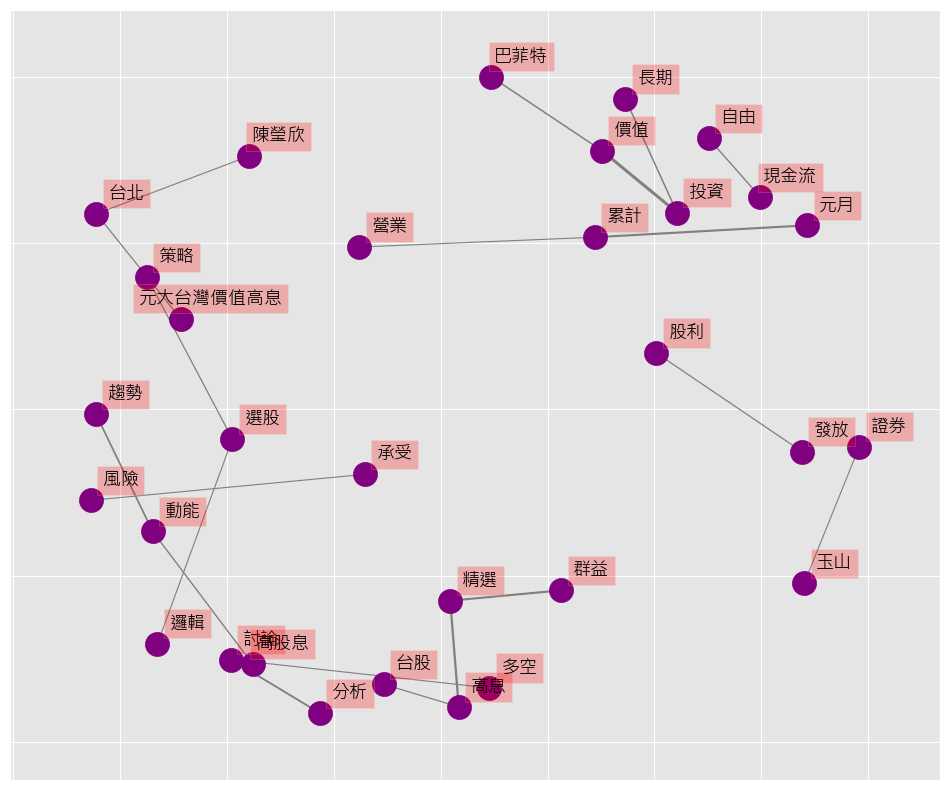

In [481]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = next.spring_layout(G, k=1.5)

# networks
next.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

根據節點之間的距離，能夠看出字詞之間的關聯性。 \
例如：【巴菲特、價值、投資】這幾個關鍵字就是 00940 在宣傳的時候常用的廣告 solgan。\
而記者陳瑩欣在ptt股票版發表了多篇文章，說不定是網軍來增加 00940 股票熱度的。

### Pairwise correlation

In [460]:
df_correlation = df_sentenced.copy()

df_correlation['word'] = df_correlation['sentence'].apply(getToken).map(' '.join)
df_correlation.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1706326839.A.D0...,[新聞]元大加入月配息ETF戰場！00940發行價10,2024-01-27 11:40:33,原文標題：\n\n元大加入月配息ETF戰場！00940發行價10元、有收益平準金、3月11號...,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入 配息 戰場 發行價 元有 收益平準金 月號 募集 聯合 新聞網 綜合 國內 發行...
1,2,https://www.ptt.cc/bbs/Stock/M.1706800255.A.4A...,[情報]0201上市櫃外資投信買超金額排行,2024-02-01 23:10:53,外資\n\n排行 股票名稱 百萬 收盤價 漲跌\n\n1 2330...,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票 名稱 百萬 收盤價 漲跌 台積電 長榮 奇鋐 文曄 廣達 世芯 台達電 中...
2,3,https://www.ptt.cc/bbs/Stock/M.1706842681.A.08...,[新聞]Meta獲利翻逾2倍史上首次發放股息盤後,2024-02-02 10:57:59,原文標題：\n\nMeta獲利翻逾2倍 史上首次發放股息 盤後股價飆超14%\n\n原文連結...,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 鉅亨網 編譯 廣告 業務 增速 勝過 對手...
3,4,https://www.ptt.cc/bbs/Stock/M.1707063537.A.AD...,[標的]00941上游半導體和費半？,2024-02-05 00:18:55,1. 標的： 00941中信上游半導體ETF\n 費城半導體...,標的中信上游半導體費城半導體分類討論正文剛剛在找資料意外看到又又又一檔即將開募奇的是開募日竟...,中信上游半導體 費城 半導體 討論 剛剛 資料 意外 看到 一檔 開募 開募 這兩 天才 准...
4,5,https://www.ptt.cc/bbs/Stock/M.1707120349.A.22...,[情報]0205上市外資買賣超排行,2024-02-05 16:05:46,1. 標題：0205 上市外資買賣超排行\n\n2. 來源：TWSE\n\n3. 網址：\n...,標題上市外資買賣超排行來源網址內文買超排行證券代號證券名稱買超張數元大滬深正國泰智能電動車台...,上市 外資 買賣 排行 來源 買超 排行 證券 代號 證券 名稱 買超 張數 元大滬深 國泰...


In [461]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(df_correlation["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
df_dtm = pd.DataFrame(columns = vocabulary, data = X.toarray())
df_dtm.head()

,一堆,一定,一檔,一次,一直,一起,一點,三大,上市,上漲,...,需要,預估,預計,領到,領息,風險,高息,高股息,高點,鴻海
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4,0,0,5,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,2,2,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2,0,0


In [462]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(df_dtm.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = df_dtm.columns, columns = df_dtm.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一堆,一定,一檔,一次,一直,一起,一點,三大,上市,...,需要,預估,預計,領到,領息,風險,高息,高股息,高點,鴻海
0,一堆,1.000000,0.059330,0.032192,-0.052805,0.086541,0.031715,-0.005019,0.029640,0.007458,...,-0.024797,-0.011394,0.100625,0.056366,0.000357,-0.003651,-0.039388,0.164013,-0.006941,-0.045561
1,一定,0.059330,1.000000,0.027648,-0.024473,-0.002374,-0.047724,0.089674,0.053508,-0.116207,...,0.129777,-0.002907,0.118166,0.249911,-0.018623,0.021913,-0.050065,0.136220,0.124011,-0.053503
2,一檔,0.032192,0.027648,1.000000,-0.046300,0.046157,0.039495,0.241590,-0.043827,-0.032524,...,0.104392,0.043517,0.132769,0.067472,0.048954,0.051221,0.184127,0.358922,0.100384,-0.039948
3,一次,-0.052805,-0.024473,-0.046300,1.000000,0.176807,-0.034660,-0.038984,0.093189,-0.034893,...,-0.021148,0.066350,0.131550,0.000420,0.415202,0.037662,-0.033593,0.139882,-0.053912,-0.038857
4,一直,0.086541,-0.002374,0.046157,0.176807,1.000000,0.021055,-0.028765,0.016841,-0.011810,...,-0.062385,-0.038615,0.031206,-0.030615,-0.048338,0.001086,-0.013222,0.120806,0.032750,-0.054809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,風險,-0.003651,0.021913,0.051221,0.037662,0.001086,0.048060,0.064436,-0.044253,-0.030960,...,0.261140,-0.015437,0.153308,0.139282,0.101057,1.000000,-0.040943,0.080877,0.046041,-0.049594
296,高息,-0.039388,-0.050065,0.184127,-0.033593,-0.013222,0.046825,-0.053039,-0.026972,0.157345,...,-0.010963,0.352086,0.041542,0.124430,-0.046625,-0.040943,1.000000,0.217682,-0.058730,0.056592
297,高股息,0.164013,0.136220,0.358922,0.139882,0.120806,-0.028294,0.415610,0.139210,-0.070190,...,0.118884,0.136890,0.135516,0.224250,0.210312,0.080877,0.217682,1.000000,0.280390,-0.037975
298,高點,-0.006941,0.124011,0.100384,-0.053912,0.032750,-0.041492,0.136612,-0.051032,0.036664,...,0.142083,0.103531,0.035110,0.195127,0.032015,0.046041,-0.058730,0.280390,1.000000,-0.046516


In [463]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
13107,累計,元月,0.939148
62143,元月,累計,0.939148
10592,巴菲特,價值,0.903593
27635,價值,巴菲特,0.903593
16454,趨勢,動能,0.894383
76254,動能,趨勢,0.894383
67081,產業,聯詠,0.849386
54523,聯詠,產業,0.849386
18683,完成,受理,0.847917
24962,受理,完成,0.847917


In [464]:
stock_sum = word_cor_df[(word_cor_df["word1"] == "元大臺灣價值高息")].sort_values(by = ['cor'], ascending = False).head(10)
profit_sum = word_cor_df[(word_cor_df["word1"] == "巴菲特")].sort_values(by = ['cor'], ascending = False).head(10)

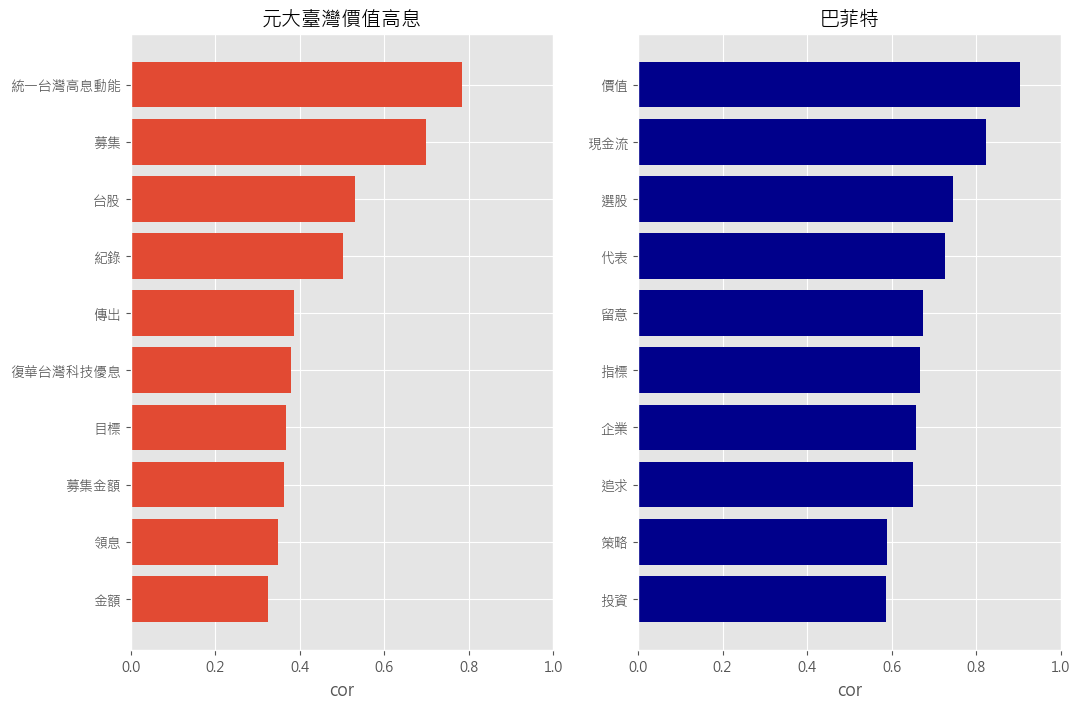

In [465]:
plt.figure(figsize=(12,8))   
plt.style.use("ggplot")     

plt.subplot(121)
plt.title('元大臺灣價值高息')
plt.xlabel('cor')
plt.barh(stock_sum['word2'],stock_sum['cor'])
plt.xlim(0, 1)
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('巴菲特')
plt.xlabel('cor')
plt.barh(profit_sum['word2'],profit_sum['cor'],color="darkblue")
plt.xlim(0, 1)
plt.gca().invert_yaxis()

plt.show()

1. 「台灣價值高息」關鍵字作圖，相關係數排名前十的相關詞彙有「統一台灣高息動能、復華台灣科技優息」這兩支股票，這兩支股票都是近期推出的高股息投資標的，也是最經常被拿來與「台灣價值高息」比較的對象。

2. 「巴菲特」關鍵字作圖，相關係數排名前十的相關詞彙有「現金流、指標」關鍵字，所對應到的是巴菲特自身推崇的"價值投資法則"，其中包含「穩定現金流、推崇財務指標」的法則。

### 繪製詞頻前60高的節點，其相關性要 > 0.3

In [466]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = df_dtm.sum().sort_values(ascending=False)\
    .head(60).reset_index().rename(columns={'index':'word', 0:'count'})
most_freq_word = most_freq_df['word'].tolist()
most_freq_df.head()


In [468]:
# 保留存在詞頻前60高之詞彙的組合
df_filtered = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
df_filtered = df_filtered[df_filtered['cor'] > 0.5]
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.head()

,word1,word2,cor
0,元大投信,價值,0.596847
1,投資,價值,0.594135
2,指數,價值,0.501233
3,國泰,元大,0.587655
4,價值,元大投信,0.596847


### 改用相關係數作為權重繪製網路圖

In [469]:
g = next.Graph()

for i in range(len(df_filtered)):
    g.add_edge(df_filtered["word1"][i], df_filtered["word2"][i], weight=df_filtered["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

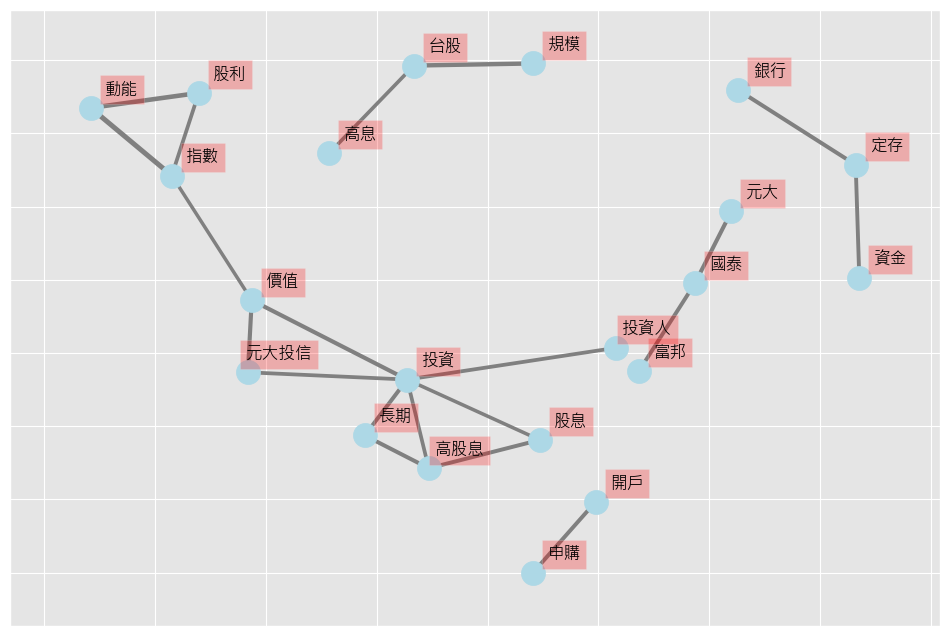

In [470]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = next.spring_layout(g, k=0.4)

# networks
next.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

上圖是利用字詞的相似度所建立的圖表，觀察連結較多的「`投資`」字詞，相關性最高的幾個詞彙為「`長期`、`股息`、`高股息`」。


In [471]:
df_similar = df_tokened.copy()
df_similar.head(3)

,system_id,sentence,word
0,1,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入 配息 戰場 發行價 元有 收益平準金 月號 募集 聯合 新聞網 綜合 國內 發行...
1,2,外資排行股票名稱百萬收盤價漲跌台積電長榮奇鋐文曄廣達世芯台達電中信金技嘉祥碩資料來源投信排行...,外資 排行 股票 名稱 百萬 收盤價 漲跌 台積電 長榮 奇鋐 文曄 廣達 世芯 台達電 中...
2,3,原文標題獲利翻逾倍史上首次發放股息盤後股價飆超原文連結發布時間記者署名鉅亨網編譯羅昀玫原文內...,獲利 翻逾倍 史上 首次 發放 股息 股價 飆超 鉅亨網 編譯 廣告 業務 增速 勝過 對手...


In [472]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
X = vectorizer.fit_transform(df_similar['word'])
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
df_tfidf = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
df_tfidf.head()

TfidfTransformer()


,一堆,一定,一檔,一次,一直,一起,一點,三大,上市,上漲,...,需要,預估,預計,領到,領息,風險,高息,高股息,高點,鴻海
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.048155,0.209721,0.000000,0.095947,0.139452,0.000000,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.030327,0.0,...,0.0,0.092771,0.091082,0.000000,0.000000,0.000000,0.000000,0.000000,0.044751,0.0
3,0.0,0.0,0.14529,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.111423,0.000000,0.082535,0.000000,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.061210,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.062178,0.162668,0.000000,0.0


In [474]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())
df_cos = pd.DataFrame(cosine_matrix[0], columns = ['cos_similarity'])
df_cos.head()

,cos_similarity
0,1.000000
1,0.075790
2,0.102055
3,0.106943
4,0.112063
...,...
222,0.108323
223,0.096748
224,0.029144
225,0.000000


找出與第一篇內容相關性最高的文章

In [475]:
df_cos_1 = df_cos.copy()
df_cos_1 = df_cos_1.merge(df_similar, how = 'left', left_index=True, right_index=True)
df_cos_1.sort_values(by = 'cos_similarity', ascending = False).head(10)

,cos_similarity,system_id,sentence,word
0,1.000000,1,原文標題元大加入月配息戰場發行價元有收益平準金月號募集原文連結發布時間聯合新聞網綜合報導記者...,元大 加入 配息 戰場 發行價 元有 收益平準金 月號 募集 聯合 新聞網 綜合 國內 發行...
67,0.746363,68,原文標題萬就能買的月配息下周一開募成分股優勢一次看原文連結發布時間年月日週一下午記者署名陳依...,就能 配息 周一 開募 成分股 優勢 一次 週一 下午 依旻 財經 特派 坐擁 巴菲特 價值...
84,0.745260,85,原文標題到底有多狂兩天吸金近千億元原文連結發布時間記者署名蔡靜紋原文內容元大臺灣價值高息到底...,有多狂 兩天吸 金近 千億元 蔡靜紋 元大 價值 高息 有多香 申購 人潮 累癱 一堆 銀行...
79,0.727388,80,原文標題有多夯申購第二天金額估破億原文連結發布時間年月日週二下午記者署名陳依旻財經特派記者原...,申購 第二天 金額 破億 週二 下午 依旻 財經 特派 坐擁 巴菲特 價值 投資 配息 萬元...
52,0.565195,53,原文標題存張月領逾萬受青睞爆預購人潮原文連結發布時間發佈時間最後更新時間記者署名作者鏡週刊責...,存張 月領 逾萬受 青睞 預購 人潮 發佈 時間 最後 更新 時間 作者 週刊 責任 編輯 ...
90,0.447337,91,原文標題募破千億無上限元大投信罕見發聲注意風險承受能力原文連結發布時間記者署名記者陳瑩欣台北...,破千 億無 上限 元大 投信 罕見 發聲 注意 風險 承受 能力 陳瑩欣 台北 元大台灣價值...
115,0.398008,116,舉例來說元大臺灣價值高息其他券商能不能出某某臺灣價值高息假若可以每個券商都會出臺灣價值來募集...,舉例 元大 價值 高息 券商 能不能 某某 價值 高息 每個 券商 都會 價值 募集 台股 ...
132,0.388353,133,標的元大臺灣價值高息分類心得分析正文投資者在投資產品前最重要的就是必須想清楚這筆資金追求的是...,元大 價值 高息 分析 投資 投資 重要 想清楚 這筆 資金 追求 報酬 長期 資本 利得 ...
156,0.386987,157,原文標題來了野村臺灣趨勢動能高股息月開募原文連結發布時間記者署名記者張慧雯台北報導原文內容元...,野村 趨勢 動能 高股息 月開 慧雯 台北 元大台灣價值高息 昨日 正式 募集 募集 首日 ...
206,0.376603,207,原文標題高股息名稱誤導投資人黃天牧深有同感原文連結發布時間記者署名工商時報戴瑞瑤魏喬怡原文內...,高股息 名稱 誤導 投資人 黃天牧 深有 同感 工商時報 戴瑞瑤 魏喬怡 高股息 名稱 誤導...
